# Solving the MNIST dataset using Convolutional Neural Networks

MNIST is a famous dataset containing a large number of handwritten single-digit numbers that is commonly used for training image processing systems and testing machine learning models.

MNIST consist of 28x28pixel images labeled 0 to 9, the **train** dataset consists of 60.000 images, while the **test** dataset consists of 10.000 images, both the train and test sets have a fairly distributed number of digits, this prevents prominent bias in the model training over the dataset.

Training a NN consists of `N` main steps:
- Feeding the NN with an element of the train set
- Comparing the expected output with the one predicted by the model
- Using the predicion error as input for a process gradient **gradient descent**: a process in which the error is used, in conjunction with a learning rate constant and the inverse derivative of each layer of the NN, to tune the parameters of the model and thus reducing the subsequent prediction error
- This cycle is repeated a certain number of time with all the elements in the train set and finally the model gets evaluated on a test set: this set consists of data the model didn't learn on, a good accuracy on the test set ensures that the model correctly learned the general concept without overfitting the train set

In [ ]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
from keras.utils import plot_model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Although this dataset could be fairly classified with a really simple MLP with just 1 dense hidden layer (in fact I tested a simple 1024-neurons hidden layer with a ReLU activation function), in this example an additional 2D convolution layer has be added before the dense layer for a variety of reasons:
- Even if, in theory, a 3 nonlinear-layer neural network is able to approximate any given function, the number of neurons required in the hidden layer easily explodes with the complexity of the function (with the extreme case in which an infinitely number of neurons in the hidden layer making it a vialble alternative representation of an infinite-dimensions image of a kernel function applied to the input, prior to the classification via a linear classifier)
- 2D Convolution is known to be able to effectively extract edge features from an image, allowing for a better classification with a smaller model

For comparison, (refer to the Keras description and graph): model **A** is about 3MB in size, while the used model **B** is about 350KB, with similar if not better accuracy.

<p style="page-break-after:always;"></p>

## Model A

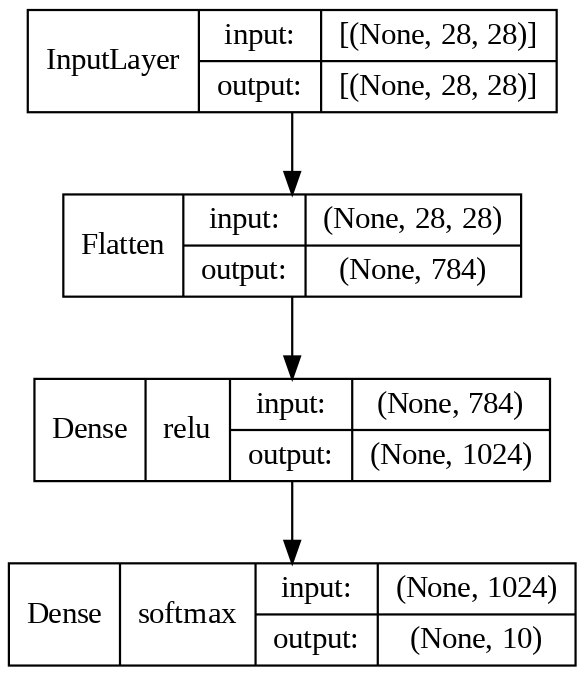

In [ ]:
model_a = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(10,   activation='softmax')])

plot_model(model_a,
           show_layer_names=False,
           show_shapes=True,
           show_layer_activations=True,
           dpi=160)

<p style="page-break-after:always;"></p>

## Model B

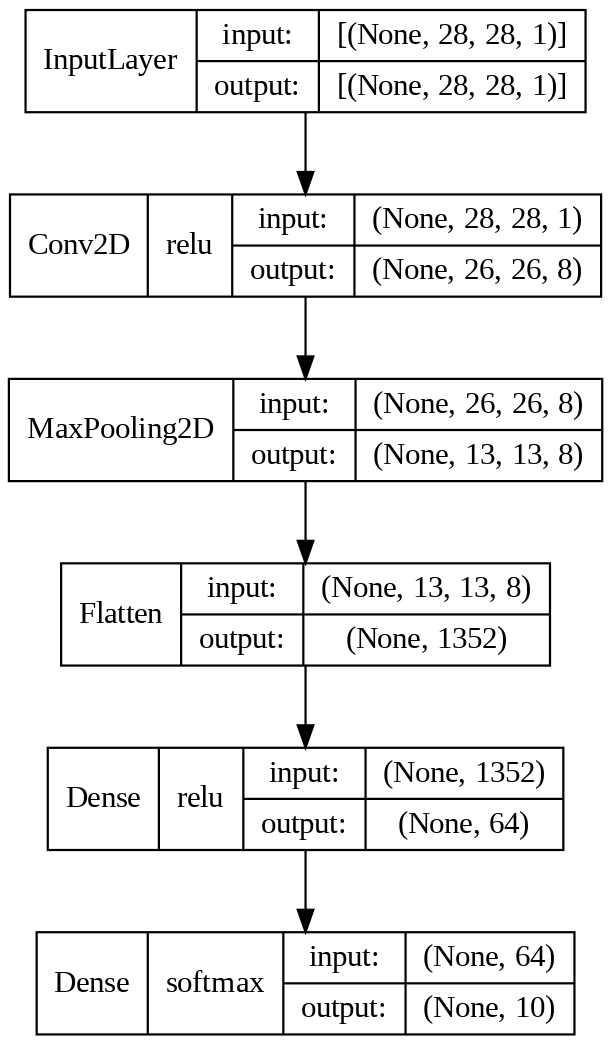

In [ ]:
model_b = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2], 1)),
    Conv2D(8, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size  = (2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')])

plot_model(model_b,
           show_layer_names=False,
           show_shapes=True,
           show_layer_activations=True,
           dpi=160)

<p style="page-break-after:always;"></p>

## Data preprocessing

Before blindly feeding any machine learning model with a dataset is important to preprocess the data to help the model to learn faster:
- In the case of time series, for example, is important to get rid of eccessive noise using a filter
- In case of a small or repetitive dataset, data augmentation may be required to present the model with different variations of the same data to help it learning the general concept without overfitting the train set
- Data augmentation may also be required if a classification dataset is very unbalanced towards one of the classes, in this case the model may "learn" that one of the classes is statistically more frequent than the others and be biased on categorizing data into that class

Luckily the MNIST is a famous and well established dataset, even if some data augmentation is possible to improve the model's accuracy (mainly consisting of rotating and translating the digits), the discussed problems have all been already taken into account.

The following histogram shows the distribution of labels among the 10 possible calsses

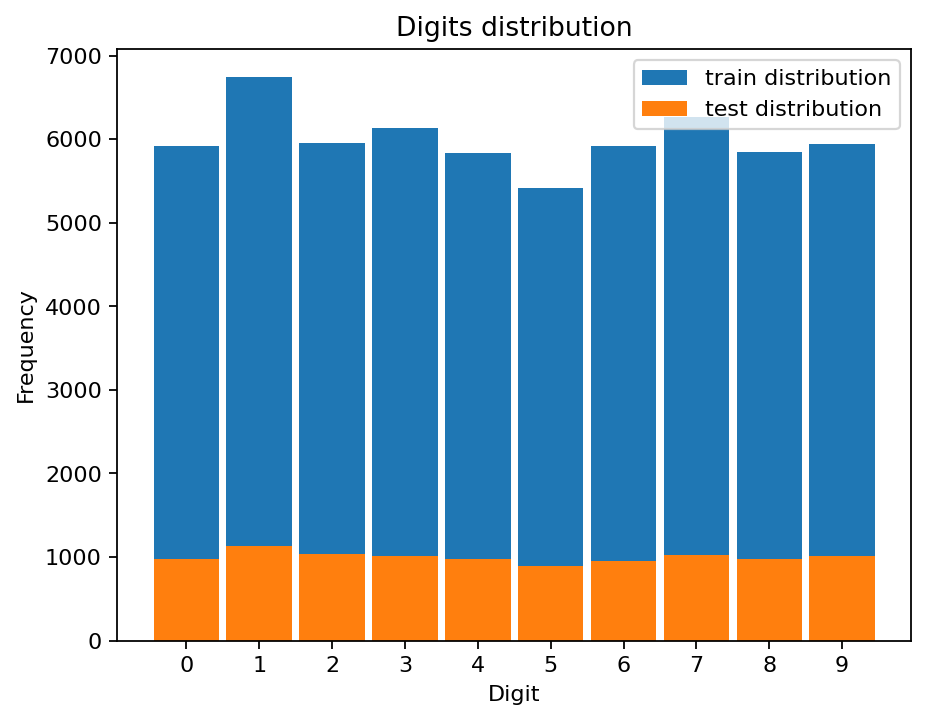

In [ ]:
plt.figure(dpi=160)
plt.hist(y_train,
         bins=[0,1,2,3,4,5,6,7,8,9,10],
         rwidth=0.9,
         label = 'train distribution',
         align = 'left')
plt.hist(y_test,
         bins=[0,1,2,3,4,5,6,7,8,9,10],
         rwidth=0.9,
         label = 'test distribution',
         align = 'left')
plt.title('Digits distribution')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.legend()
plt.show()

<p style="page-break-after:always;"></p>

## Adapting labels for training

In datasets for classifications labels are usually characters, strings or integers.
This is a reasonable way to represent classes both because they can be easily retrived  by either directly using their names or some integer indexes, but also because this representation allows to save some memory in the dataset.

We could use as output a single neuron outputting a number in the range $[0-9]$ but this comes with multiple problems:
- A floating point value makes no logical sense, since this is a classification and not a regression problem
- In case of multiple classes with high probability a completely random class may be picked (e.g.: classifying a number it may happen to confuse a `3` and an `8` since they are visibly really similar, in a case like this a model that simply outputs a single-digit number will probably output the mathematical average of the two classes `5.5` that not only is completely off from both classes, but also doesn't make lot of sense since it leads to the problem of choosing a class between `5` and `6`)

So this representation is not optimal for the learning process, instead a different representation of the classes is used.
The categorical representation of a label for class $C_i$ in a set of $N$ classes consists of a vector of size $N$ containing only zeroes, except for the element in position $i$ that is 1

If, for example, $x$ belongs to class $i$, its representation is

$C(x) = \{0,1\}^N
\left\{
\begin{array}{ll}
  C(x)_j = 0, \text{if  } j \neq i\\
  C(x)_j = 1, \text{if  } j = i
\end{array}\right.$

In [ ]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Following is the size of the data and labels of the dataset after preprocessing

In [ ]:
print(f"""Shape of x_train:
    {x_train.shape}""")
print(f"""Shape of x_test:
    {x_test.shape}""")
print(f"""Shape of y_train:
    {y_train.shape}""")
print(f"""Shape of y_test:
    {y_test.shape}""")

Shape of x_train:
    (60000, 28, 28)
Shape of x_test:
    (10000, 28, 28)
Shape of y_train:
    (60000, 10)
Shape of y_test:
    (10000, 10)


## Training

Now comes the actual training of the model,
note that the loss metric is `categorical_crossentropy` since we are using a categorical representation of the output (otherwise `sparse_categorical_crossentropy` would have been more appropriate).

The `accuracy` metric indicates how often the predicted labels equal the real labels.

In [ ]:
model_b.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_b.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 8)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1352)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                86592     
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 87322 (341.10 KB)
Trainable params: 87322 (341.10 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
history = model_b.fit(x_train, y_train,
                    epochs=10,
                    batch_size=256)

Epoch 1/10
235/235 [==============================] - 7s 28ms/step - loss: 2.1751 - accuracy: 0.7932
Epoch 2/10
235/235 [==============================] - 7s 32ms/step - loss: 0.3225 - accuracy: 0.9201
Epoch 3/10
235/235 [==============================] - 8s 34ms/step - loss: 0.1934 - accuracy: 0.9497
Epoch 4/10
235/235 [==============================] - 6s 27ms/step - loss: 0.1372 - accuracy: 0.9635
Epoch 5/10
235/235 [==============================] - 7s 30ms/step - loss: 0.1053 - accuracy: 0.9703
Epoch 6/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0817 - accuracy: 0.9760
Epoch 7/10
235/235 [==============================] - 7s 31ms/step - loss: 0.0670 - accuracy: 0.9795
Epoch 8/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0570 - accuracy: 0.9831
Epoch 9/10
235/235 [==============================] - 7s 31ms/step - loss: 0.0462 - accuracy: 0.9857
Epoch 10/10
235/235 [==============================] - 8s 32ms/step - loss: 0.0434 - accura

## Looking into the model

To check if our model is learning we can compare its accuracy and loss over the multiple epochs of training, ideally the accuracy will grow closer to 1 the more time we train in on the training data and at the same time the loss will shrink down to 0.

This proves that our model is powerful enough to fit the training data, but is not enough for evaluating its performance in a real scenario.

As said before to evaluate a model we must be sure that it learned the general concept without overfitting the training data we provided.
To do this we evaluate the model again using the test set, which is a set of data that our model never saw before so there is no way it could overfit that.

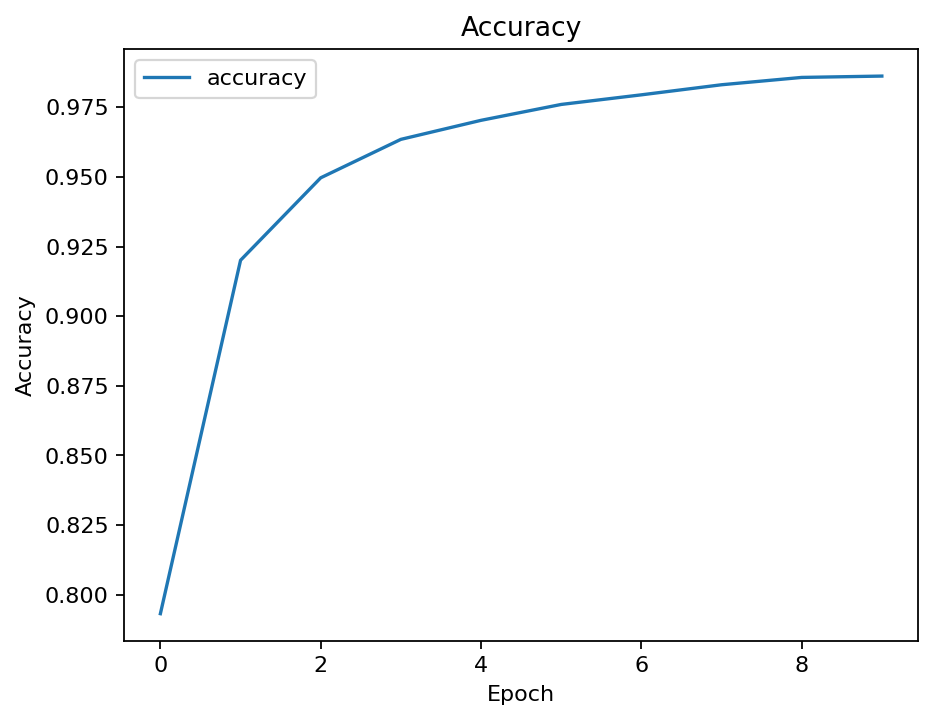

In [ ]:
plt.figure(dpi=160)
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

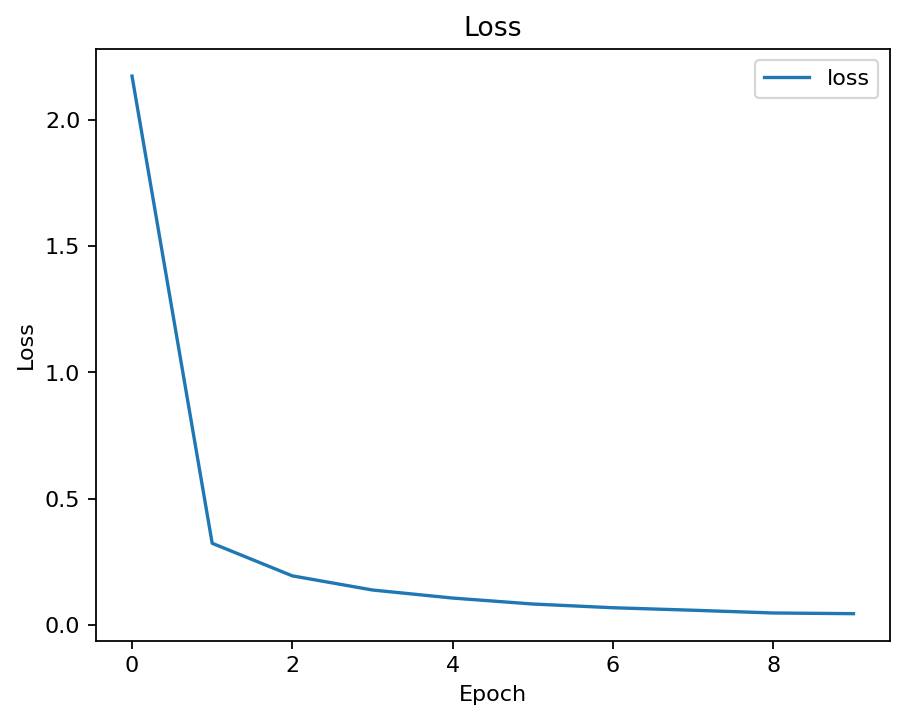

In [ ]:
plt.figure(dpi=160)
plt.plot(history.history['loss'],     label='loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<p style="page-break-after:always;"></p>

In [ ]:
score = model_b.evaluate(
    x_test,
    y_test,
    verbose = 1)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

313/313 [==============================] - 2s 5ms/step - loss: 0.1461 - accuracy: 0.9687
Test loss: 0.1461125910282135
Test accuracy: 0.9686999917030334


## A deeper look into the model

Neural Networks are models with low **interpretability**, that means that it's difficult to fully understand how the model work in it's entirety.

Even if we know the working of some of its parts, for example it's known that convlutoin layer is responsible for edges detection, it's hard to address a single point of the model's architecture responsible for a good or bad detection.

To indirectly understand a model, a useful tool is its **confusion matrix** (computed on the test data).

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model_b.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 3ms/step


## The confusion matrix

The confusion matrix is a 2-way table constructed by comparing the output of the model on a certain data point to its actual label, these are used as coordinates in the table to increase a conuter in the selected cell.

1. Set all cells to 0
2. assign an index to each class
3. For each point $x_k$ in the test set, classify it using the model and, being $i$ the index of the actual class and $j$ the index of the predicted class, increase $M_{ij}$ by $1$

An ideal confusion matrix is perfectly diagonal (that means all data gets correctly classified)

The result is a map that shows all the correct and incorrect predictions, providing also informations such as:
- Which misspredicion between 2 classes is more frequent?
- Which classes are more likely to be outputted in the prediction?
- Is the model complexity appropriate?

One way in which confusion matrix may represent a bad model is the presence of sparse non-zero values not belonging to the diagonal (in this case, even if not prominent, number `4` gets sometimes confused to `9`, this can be caused by how similar these two numbers are in hand-written form). This often indicates that the dataset is noisy in those features that are used to distinguish the two classes or that the classes are too similar to be distinguished by the model.

Another characteristic of a "bad" confusion matrix is a prominent imbalance in its columns, this means that some predictions are way more probable than ohers and indicates a huge bias in the model prediction. This may happen etiher:
1. a model is too simple (a simpler model has usually higher bias and lower variance than a more complex one)
2. The dataset is highly unbalanced, that means that some classes are way more frequent than others and for the model is more convenient to "gamble" on those classes instead of learning the needed concept.

Lastly, a uniformly distributed matrix is sign that a model is not suitable to extract any useful feature from the dataset, the noise-information ratio is too high, or that no meaningful implication exists between the data and and labels collected.

In this case, asid for some minor noise on the upper and lower part of the matrix, the shape is indoubtly diagonal,

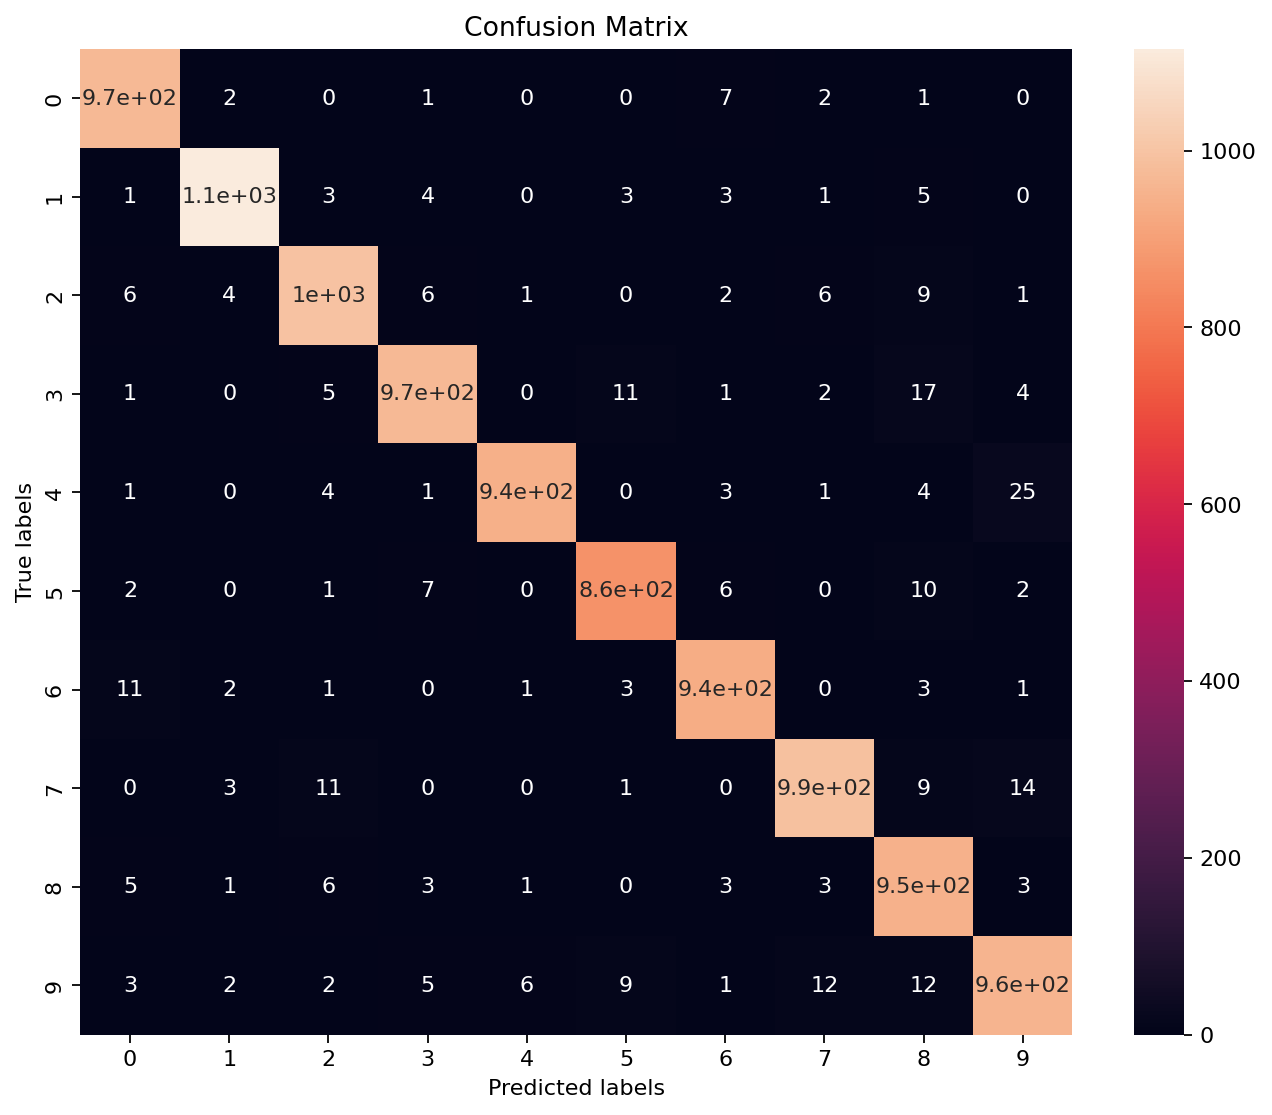

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (10, 8), dpi=160)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

plt.show()

<p style="page-break-after:always;"></p>

## More precise report

For a more precise report on the classification is also possible to use sklearn's `classification_report` method, that helps extract many parameters, in a less graphical but more formal, precise and algorithmic way

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(
    y_true,
    y_pred,
    target_names = [
        'Digit 0', 'Digit 1', 'Digit 2', 'Digit 3', 'Digit 4',
        'Digit 5', 'Digit 6', 'Digit 7', 'Digit 8', 'Digit 9']))

              precision    recall  f1-score   support

     Digit 0       0.97      0.99      0.98       980
     Digit 1       0.99      0.98      0.98      1135
     Digit 2       0.97      0.97      0.97      1032
     Digit 3       0.97      0.96      0.97      1010
     Digit 4       0.99      0.96      0.98       982
     Digit 5       0.97      0.97      0.97       892
     Digit 6       0.97      0.98      0.97       958
     Digit 7       0.97      0.96      0.97      1028
     Digit 8       0.93      0.97      0.95       974
     Digit 9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

